In [1]:
from functools import reduce
from operator import mul
import numpy as np
import logging
from os.path import exists
from os import mkdir
import matplotlib.pyplot as plt
import matplotlib as mpl
from pickle import load, dump
import seaborn as sns
import pandas as pd
from scipy import stats

from assignment.util import *
from assignment.TSP import *
from assignment.cooling import *
from assignment.SAMinimizer import *

logging.basicConfig(level = logging.INFO)

f64 = np.float64
i32 = np.int32
i64 = np.int64

mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11

SECONDARY_SAVE_DIR = "./save_data(2)"
if not exists(SECONDARY_SAVE_DIR):
    mkdir(SECONDARY_SAVE_DIR)
    

def save_path_2(filename):
    return f"{SECONDARY_SAVE_DIR}/filename"

In [2]:
def info(msg):
    print(f"[INFO] {msg}")

In [3]:
def generate_multidim_rngs(seed, *args):
    flatlen = reduce(mul, args, 1)
    rngs = generate_rngs(flatlen, seed = seed)
    rngs = np.array(rngs, dtype = np.object)
    rngs = rngs.reshape(args)
    return rngs

In [4]:
def save_path_2(filename):
    return f"{SECONDARY_SAVE_DIR}/{filename}"

In [5]:
def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
    acceptance_rates = np.full(batch_size, np.float64("nan"))
    min_costs = np.full(batch_size, np.float64("nan"))
    node_count = sa_system.delta_cost.D.shape[0]
    for i in range(batch_size):
        X0 = np.random.permutation(node_count)
        sa_system.run(chain_length, T_initial, X0, *args)
        min_costs[i] = sa_system.min_cost
        acceptance_rates[i] = np.float64(sa_system.acceptance_count)/chain_length
        sa_system.reset()
        
    return min_costs, acceptance_rates

In [6]:
DEFAULT_TRANSITIONS = (random_two_opt_transition, Lin2opt)
transition, state_constructor = DEFAULT_TRANSITIONS

cost_func, dcost_func = COST_FUNCTION_PAIRS[1]
node_count = first(cost_func.D.shape)
assert node_count == 280 == first(dcost_func.D.shape)

## Initial Acceptance Rate $\eta$ vs. $T_0$

In [7]:
# outer loop of parameter sweep
chain_lengths = np.linspace(1000, 5000, 5, dtype = np.int32)



cost_probing = CostProbing.LATEST_GLOBAL_OPTIMUM
stopping = StoppingCriterion.MKOV_CHAIN_COUNT
chain_count = 1
# does not matter as we are running only one chain, no cooling required
cooling = GeometricCoolingSchedule(0.5)


root_N = np.sqrt(node_count)
_start_c_value = 10
_end_c_value = 30
c_values = np.arange(_start_c_value, _end_c_value, dtype = f64)
#inner loop of parameter sweep
T0_values = c_values * root_N

args = (cost_func, stopping, cost_probing, chain_count)

batch_size = 20

Ni = len(chain_lengths)
Nj = len(T0_values)
# for chain_len in chain_lengths
#     for T0 in T0_values
#         run_batch()


rngs = np.array([generate_rngs(Nj, seed = 0xc0ffee_1337) for _ in range(Ni)], dtype = np.object)

        

npz_filename = "a280_proto_param_sweep.npz"
npz_filepath = save_path_2(npz_filename)

acceptance_rates = np.full((Ni,Nj,batch_size), np.float64("nan"))

if not exists(npz_filepath):
    #     logging.info("Performing parameter sweeps...")
    print("[INFO]: Performing parameter sweeps...")
    for i,clen in enumerate(chain_lengths):
        #         logging.info(f"Done with {i} of {Ni} chain length values")
        print(f"[INFO]: Done with {i} of {Ni} chain length values")
        for j,T0 in enumerate(T0_values):
            system = SAMinimizer(transition, dcost_func, cooling, rngs[i][j].uniform, state_constructor)
            _, η_values = run_batch(system, batch_size, clen, T0, *args)
            assert η_values.shape == (batch_size,)
            acceptance_rates[i][j] = η_values
            
    np.savez(npz_filepath, acceptance_rates)
else:
    with np.load(npz_filepath) as save_data:
        acceptance_rates = save_data['arr_0']

In [8]:
mean_η_values = [np.mean(η_matrix, axis = 1) for η_matrix in acceptance_rates]
std_η_values = [np.std(η_matrix, axis = 1) for η_matrix in acceptance_rates]

In [9]:
print(mean_η_values[-1])

[0.7599625 0.7781125 0.7985375 0.8126875 0.82735   0.8392875 0.8488
 0.85685   0.8633875 0.8725875 0.8799375 0.8835125 0.889325  0.8927
 0.899875  0.9026625 0.905425  0.90855   0.91315   0.917275 ]


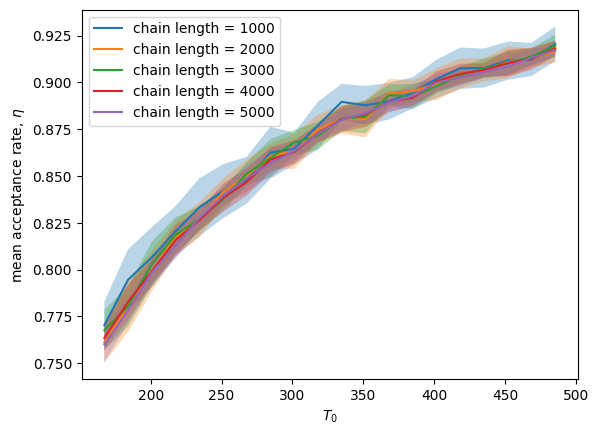

In [10]:
# These are the mean acceptance rates for different chain values.
# Looks messy, would be better plotted in separate graphs
# Couldn't figure out quickly enough how to create separate
# figures and loop over them
# TODO: change from lines to linespoints 
plt.xlabel("$T_0$")
plt.ylabel("mean acceptance rate, $\eta$")
for i,acc_rates in enumerate(acceptance_rates):
    clen = chain_lengths[i]
    mean_acc_rates = np.mean(acc_rates, axis = 1)
    std_acc_rates = np.std(acc_rates, axis = 1)
    plt.plot(T0_values, mean_acc_rates, label = f"chain length = {clen}")
    plt.fill_between(T0_values, mean_acc_rates - std_acc_rates, mean_acc_rates + std_acc_rates, alpha = 0.3)
plt.legend()
plt.show()

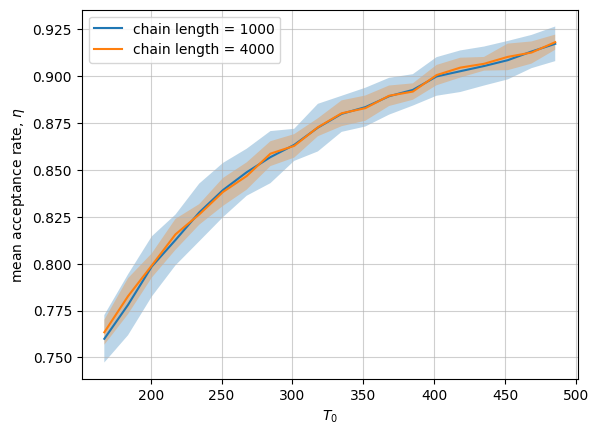

In [11]:
# TODO: change from lines to linespoints
plt.xlabel("$T_0$")
plt.ylabel("mean acceptance rate, $\eta$")
ind = 0
acc_rates = acceptance_rates[ind]
std_acc_rates = np.std(acc_rates, axis = 1)
plt.plot(T0_values, mean_acc_rates, label = f"chain length = {chain_lengths[ind]}")
plt.fill_between(T0_values, mean_acc_rates - std_acc_rates, mean_acc_rates + std_acc_rates, alpha = 0.3)

mean_acc_rates = np.mean(acc_rates, axis = 1)
std_acc_rates = np.std(acc_rates, axis = 1)
ind = -2
acc_rates = acceptance_rates[ind]
mean_acc_rates = np.mean(acc_rates, axis = 1)
std_acc_rates = np.std(acc_rates, axis = 1)
plt.plot(T0_values, mean_acc_rates, label = f"chain length = {chain_lengths[ind]}")
plt.fill_between(T0_values, mean_acc_rates - std_acc_rates, mean_acc_rates + std_acc_rates, alpha = 0.3)
plt.grid(alpha = 0.6)
plt.legend()
plt.show()

We choose to stick with chain length $4000$ to get reliable initial acceptance rates

## Visualization of Cooling Schedules

In [12]:
def geometric_steps_c(T0, Tf, steps):
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return np.exp(np.log(Tf/T0)/steps)

def linear_steps_c(T0, Tf, steps):
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return (T0 - Tf)/steps

def log_steps_c(T0, Tf, steps):
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return (T0/Tf - 1.0)/(np.log(1+steps))

def exp_steps_c(T0, Tf, steps):
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return -np.log((Tf/T0))/steps

In [13]:
T0 = 1000
Tf = 1.0

steps = 1000

args = (T0, Tf, steps)

c_geometric = geometric_steps_c(*args)
geometric_cooling = GeometricCoolingSchedule(c_geometric)


c_linear = linear_steps_c(*args)
linear_cooling = LinearCoolingSchedule(c_linear)


log_cooling = LogarithmicCoolingSchedule(2.0)


coolers = [linear_cooling, geometric_cooling]# , log_cooling]
labels = ["linear", "geometric", "log"]
cooling_timeseries = [[] for _ in coolers]

for i,cooler in enumerate(coolers):
    T = T0
    j = 0
    print(f"[INFO] Done with {i} of {len(coolers)} cooling schedules")
    while (T > Tf):
        cooling_timeseries[i].append(T)
        T = cooler(T0, j)
        j += 1
        
# doing log separately because trying to get the same final temperature results in OF (in float64)
cooling_timeseries.append([])
T = T0
print(T0)
for i in range(1,1003):
    cooling_timeseries[-1].append(T)
    T = log_cooling(T0, i)
        
print([len(t) for t in cooling_timeseries])

[INFO] Done with 0 of 2 cooling schedules
[INFO] Done with 1 of 2 cooling schedules
1000
[1001, 1002, 1002]


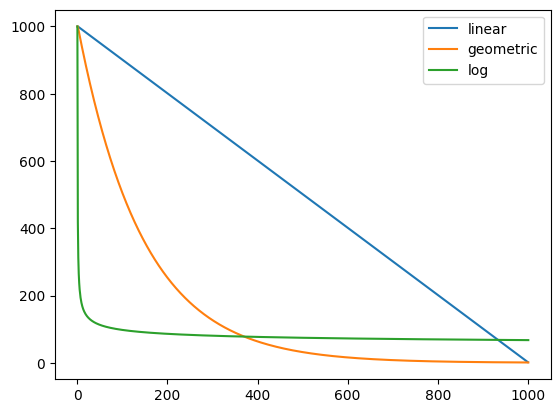

In [14]:
for i,Ts in enumerate(cooling_timeseries):
    plt.plot(range(len(Ts)), Ts, label = labels[i])
plt.legend()
    
plt.show()

## Convergence Properties by Parameter Values

### Linear Cooling

T0 = 1000.0, Tf = 1.0


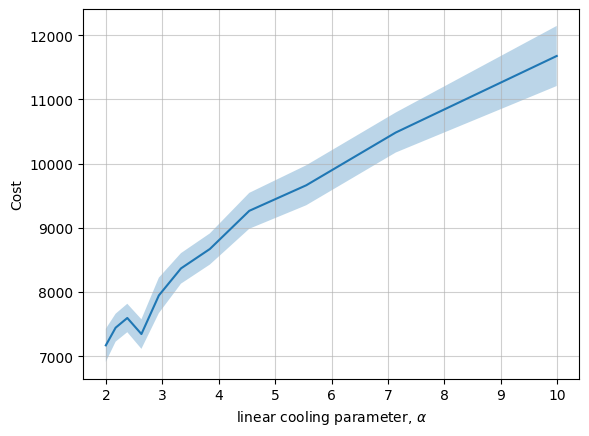

In [15]:
T0 = 1000.
Tf = 1.
chain_length = 1000

stopping = StoppingCriterion.MIN_TEMPERATURE
T_final = Tf
cost_probing = CostProbing.ACCEPTED

chain_counts = np.linspace(100., 500., 11)
linear_param_values = np.array([linear_steps_c(T0, Tf, k) for k in chain_counts])

Ni = len(linear_param_values)
batch_size = 20

npz_filename = "linear_param_sweep_a280.npz"
npz_filepath = save_path_2(npz_filename)

rngs = generate_rngs(Ni)

args = (cost_func, stopping, cost_probing, T_final)
min_costs_list = np.full((Ni, batch_size), f64('nan'))
acceptance_rates_list = np.full((Ni, batch_size), f64('nan'))
print(f"T0 = {T0}, Tf = {Tf}")

if not exists(npz_filepath):
    print("[INFO] performing parameter sweep")
    for i,p in enumerate(linear_param_values):
        print(f"[INFO] done with {i} of {Ni} batches")
        cooling = LinearCoolingSchedule(p)
        system = SAMinimizer(transition, dcost_func, cooling, rngs[i].uniform, state_constructor)
        #def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
        min_costs, acceptance_rates = run_batch(system, batch_size, chain_length, T0, *args)
        acceptance_rates_list[i] = acceptance_rates
        min_costs_list[i] = min_costs
    print("[INFO] done with all batches")
    np.savez(npz_filepath, min_costs_list, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        min_costs_list = save_data['arr_0']
        acceptance_rates_list = save_data['arr_1']
        
mean_min_costs = np.mean(min_costs_list, axis = 1)
std_min_costs = np.std(min_costs_list, axis = 1)

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)

plt.plot(linear_param_values, mean_min_costs, label = "average optimum cost")
plt.grid(alpha = 0.6)
plt.xlabel("linear cooling parameter, $\\alpha$")
plt.ylabel("Cost")
plt.fill_between(linear_param_values, mean_min_costs - std_min_costs, mean_min_costs + std_min_costs, alpha = 0.3)
plt.show()

### Geometric Cooling

T0 = 1000.0, Tf = 1.0


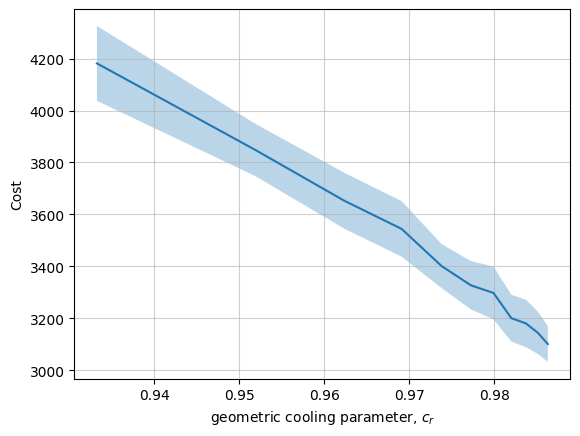

In [16]:
T0 = 1000.
Tf = 1.

stopping = StoppingCriterion.MIN_TEMPERATURE
T_final = Tf
cost_probing = CostProbing.ACCEPTED

geometric_param_values = np.array([geometric_steps_c(T0, Tf, k) for k in chain_counts])
Ni = len(geometric_param_values)

batch_size = 20

npz_filename = "geometric_sweep_a280.npz"
npz_filepath = save_path_2(npz_filename)

rngs = generate_rngs(Ni)

args = (cost_func, stopping, cost_probing, T_final)
min_costs_list = np.full((Ni, batch_size), f64('nan'))
acceptance_rates_list = np.full((Ni, batch_size), f64('nan'))
print(f"T0 = {T0}, Tf = {Tf}")

if not exists(npz_filepath):
    print("[INFO] performing parameter sweep")
    for i,p in enumerate(geometric_param_values):
        print(f"[INFO] done with {i} of {Ni} batches")
        cooling = GeometricCoolingSchedule(p)
        system = SAMinimizer(transition, dcost_func, cooling, rngs[i].uniform, state_constructor)
        #def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
        min_costs, acceptance_rates = run_batch(system, batch_size, chain_length, T0, *args)
        acceptance_rates_list[i] = acceptance_rates
        min_costs_list[i] = min_costs
    print("[INFO] done with all batches")
    np.savez(npz_filepath, min_costs_list, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        min_costs_list = save_data['arr_0']
        acceptance_rates_list = save_data['arr_1']
        
        
mean_min_costs = np.mean(min_costs_list, axis = 1)
std_min_costs = np.std(min_costs_list, axis = 1)

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)

plt.plot(geometric_param_values, mean_min_costs, label = "average optimum cost")
plt.xlabel("geometric cooling parameter, $c_r$")
plt.ylabel("Cost")
plt.grid(alpha = 0.6)
plt.fill_between(geometric_param_values, mean_min_costs - std_min_costs, mean_min_costs + std_min_costs, alpha = 0.3)
plt.show() 

### Logarithmic Cooling

T0 = 1, Tf = 0.1


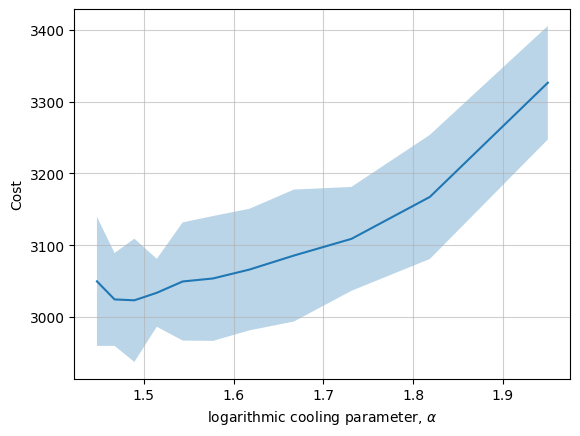

In [17]:
T0 = 1
Tf = 0.1
Ni = 16

chain_counts = np.linspace(100, 500, 11, dtype = np.int32)
log_param_values = np.array([log_steps_c(T0, Tf, k) for k in chain_counts])
Ni = len(log_param_values)

T_final = Tf
stopping = StoppingCriterion.MIN_TEMPERATURE


npz_filename = "log_param_sweep_280.npz"
npz_filepath = save_path_2(npz_filename)

rngs = generate_rngs(Ni)

args = (cost_func, stopping, cost_probing, T_final)
min_costs_list = np.full((Ni, batch_size), f64('nan'))
acceptance_rates_list = np.full((Ni, batch_size), f64('nan'))
print(f"T0 = {T0}, Tf = {Tf}")

if not exists(npz_filepath):
    print("[INFO] performing parameter sweep")
    for i,p in enumerate(log_param_values):
        print(f"[INFO] done with {i} of {Ni} batches")
        cooling = LogarithmicCoolingSchedule(p)
        system = SAMinimizer(transition, dcost_func, cooling, rngs[i].uniform, state_constructor)
        #def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
        min_costs, acceptance_rates = run_batch(system, batch_size, chain_length, T0, *args)
        acceptance_rates_list[i] = acceptance_rates
        min_costs_list[i] = min_costs
    print("[INFO] done with all batches")
    np.savez(npz_filepath, min_costs_list, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        min_costs_list = save_data['arr_0']
        acceptance_rates_list = save_data['arr_1']
        
mean_min_costs = np.mean(min_costs_list, axis = 1)
std_min_costs = np.std(min_costs_list, axis = 1)

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)

plt.plot(log_param_values, mean_min_costs, label = "average optimum cost")
plt.xlabel("logarithmic cooling parameter, $\\alpha$")
plt.ylabel("Cost")
plt.grid(alpha = 0.6)
plt.fill_between(log_param_values, mean_min_costs - std_min_costs, mean_min_costs + std_min_costs, alpha = 0.3)
plt.show() 

### Comparison
Box plots

In [18]:
chain_count = 1000
chain_length = 500
T0 = 1.0e3
Tf = 1.0

c_linear = linear_steps_c(T0, Tf, chain_count)
c_geometric = geometric_steps_c(T0, Tf, chain_count)
T0_log = 1
Tf_log = 0.1

c_logarithmic = log_steps_c(T0_log, Tf_log, chain_count)

parameters = [c_linear, c_geometric, c_logarithmic]
coolers_ctors = [LinearCoolingSchedule, GeometricCoolingSchedule, LogarithmicCoolingSchedule]
coolers = [coolers_ctors[i](p) for i,p in enumerate(parameters)]
linear_cooling, geometric_cooling, log_cooling = coolers

batch_size = 16

min_costs = np.full((len(coolers),batch_size), f64('nan'))
linear_rng, geometric_rng, log_rng = generate_rngs(3)  # order doesn't matter, but naming for readibility

# linear
# system = SAMinimizer(transition, dcost_func, cooling, rngs[i][j].uniform, state_constructor)

# system = SAMinimizer(transition, dcost_func, cooling, rngs[i][j].uniform, state_constructor)
linear_system = SAMinimizer(transition, dcost_func, linear_cooling, linear_rng.uniform, state_constructor)
geometric_system = SAMinimizer(transition, dcost_func, geometric_cooling, geometric_rng.uniform, state_constructor)
log_system = SAMinimizer(transition, dcost_func, log_cooling, log_rng.uniform, state_constructor)
systems = [linear_system, geometric_system, log_system]

# def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
args = (cost_func, stopping, cost_probing, Tf)
args_log = (cost_func, stopping, cost_probing, Tf_log)
npz_filename = "comparison.npz"
npz_filepath = save_path_2(npz_filename)
# objfile = "systems.bin"
# objpath = save_path_2(objfile)

if not exists(npz_filepath):
    min_costs[0], _ = run_batch(linear_system, batch_size, chain_length, T0, *args)
    min_costs[1], _ = run_batch(geometric_system, batch_size, chain_length, T0, *args)
    min_costs[2], _ = run_batch(log_system, batch_size, chain_length, T0_log, *args_log)
    np.savez(npz_filepath, min_costs)
else:
    with np.load(npz_filepath) as save_data:
        min_costs = save_data['arr_0']


In [36]:
def boltzmann(H, T):
    return np.exp(-H/T)

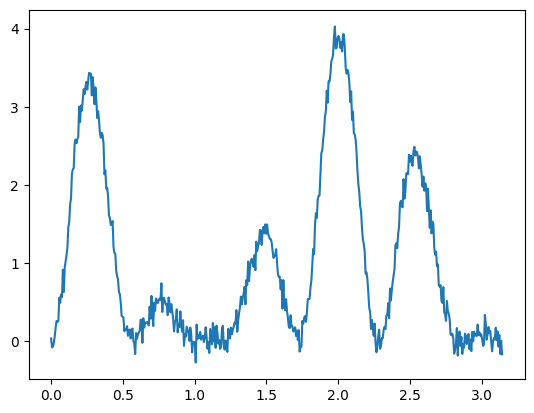

In [35]:
rng = first(generate_rngs(1))
x = np.linspace(0,np.pi,500)
y = ((np.sin(4*x) + np.sin(7*x)))**2 + rng.normal(loc = 0, scale = 0.1, size = 500)
plt.grid(alpha = 0.6)
plt.plot(x,y)
plt.show()

In [38]:
T_values = np.logspace(-2, 3, 6, base = 10)
y_boltzmann = [boltzmann(y, T) for T in T_values]

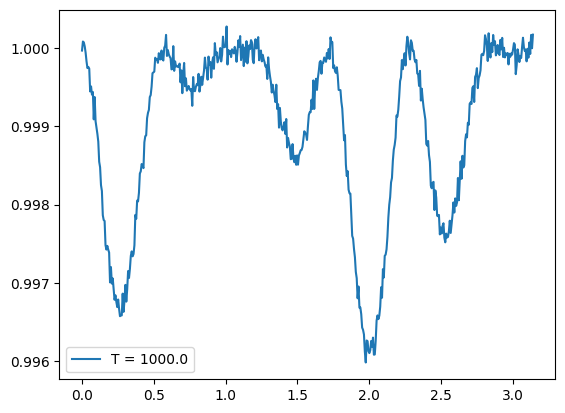

In [52]:
plt.plot(x, y_boltzmann[5], label = f"T = {T_values[5]}")
plt.legend()
plt.show()

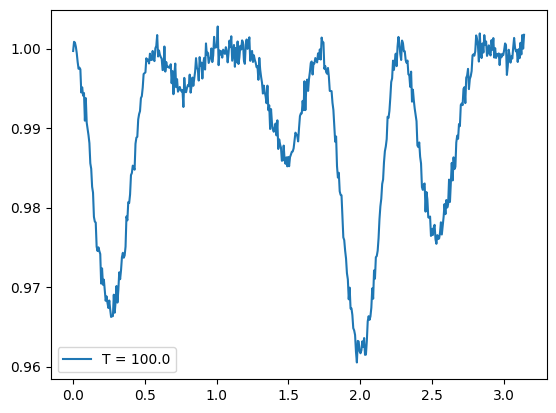

In [51]:
plt.plot(x, y_boltzmann[4], label = f"T = {T_values[4]}")
plt.legend()
plt.show()

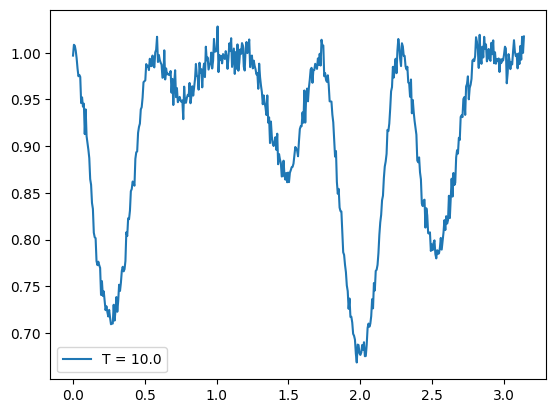

In [50]:
plt.plot(x, y_boltzmann[3], label = f"T = {T_values[3]}")
plt.legend()
plt.show()

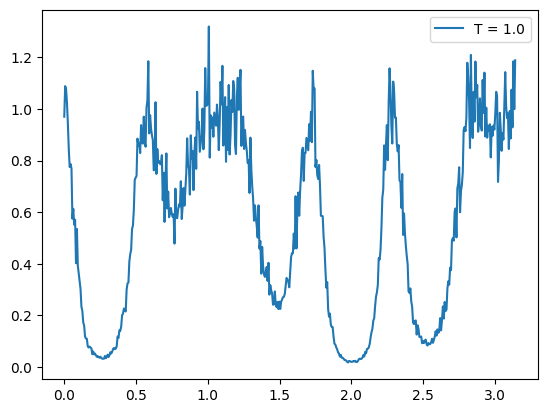

In [49]:
plt.plot(x, y_boltzmann[2], label = f"T = {T_values[2]}")
plt.legend()
plt.show()

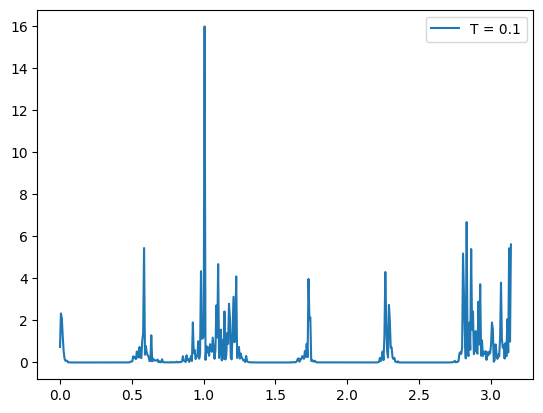

In [48]:
plt.plot(x, y_boltzmann[1], label = f"T = {T_values[1]}")
plt.legend()
plt.show()

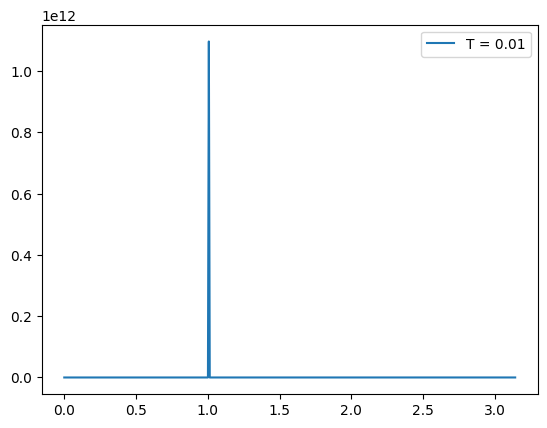

In [47]:
plt.plot(x, y_boltzmann[0], label = f"T = {T_values[0]}")
plt.legend()
plt.show()